In [1]:
import xarray as xr
import numpy as np
import cmocean # for perceptually uniform colormaps
import cartopy as cr # for geographic mapping
import cartopy.crs as ccrs # for map projections
import matplotlib.pyplot as plt # plotting tool
import cartopy.feature as cfeature # to add coastlines, land and ocean
from cartopy import config
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfea
from netCDF4 import Dataset
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib as mpl
import pandas as pd
import datetime
import os
from datetime import datetime
import matplotlib.patheffects as PathEffects
import geocat.viz as gv
import cmaps
import geocat.datafiles as gdf
import geocat.viz as gv
import geocat.viz.util as gvutil
from scipy import stats
from mpl_toolkits.basemap import Basemap, cm, shiftgrid, addcyclic
from cartopy import feature as cf
import xarray as xarray

In [2]:
def plot_background(ax):
    ax.coastlines(resolution='110m');
    ax.gridlines(draw_labels=True,linewidth=2, color='gray', alpha=0.5, linestyle="dotted")
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))      
    ax.add_feature(cfeature.LAND.with_scale('50m'))       
    ax.add_feature(cfeature.LAKES.with_scale('50m'))     
    ax.add_feature(cfeature.BORDERS.with_scale('50m'))    
    ax.add_feature(cfeature.RIVERS.with_scale('50m'))    
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',    
                        facecolor='none', name='coastline')
    ax.add_feature(coast, edgecolor='black')
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='gray')

   
    return ax

import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='lightgray', linewidth=0.5)

In [3]:
##Set up all functions
# -- regional average
def wgt_areaave(indat, latS, latN, lonW, lonE):
  lat=indat.lat
  lon=indat.lon

  if ( ((lonW < 0) or (lonE < 0 )) and (lon.values.min() > -1) ):
     anm=indat.assign_coords(lon=( (lon + 180) % 360 - 180) )
     lon=( (lon + 180) % 360 - 180)
  else:
     anm=indat

  iplat = lat.where( (lat >= latS ) & (lat <= latN), drop=True)
  iplon = lon.where( (lon >= lonW ) & (lon <= lonE), drop=True)

#  print(iplat)
#  print(iplon)
  wgt = np.cos(np.deg2rad(lat))
  odat=anm.sel(lat=iplat,lon=iplon).weighted(wgt).mean(("lon", "lat"), skipna=True)
  return(odat)


# -- Detorending
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [4]:
#Saved path
ifile = 'C:/Users/user/Research/Research Code/CNN/Data/'
outdir = 'C:/Users/user/Research/Research Code/CNN/Mechanism/1983_2022/'

# 1. Warm NDJ

In [5]:
# ----- Parameter setting ------
ystr = 1983
yend = 2022

# == netcdf file name and location"
fnc = ifile+'ersst_1854_2022_mech.nc'
dmask = xr.open_dataset('C:/Users/user/Research/Research Code/Mechanism/lsmask.nc')
print(dmask)

ds = xr.open_dataset(fnc)

# === Climatology and Anomalies
sst = ds.sst
clm = sst.sel(time=slice(f'{ystr}-01-01',f'{yend}-12-01')).groupby('time.month').mean(dim='time')
anm = (sst.groupby('time.month') - clm)

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-10-29
Data variables:
    mask     (time, lat, lon) float32 ...
Attributes:
    title:          NOAA Optimum Interpolation (OI) SST V2
    Conventions:    CF-1.0
    history:        Created 10/2002 by RHS
    comments:       Data described in  Reynolds, R.W., N.A. Rayner, T.M.\nSmi...
    platform:       Model
    source:         NCEP Climate Modeling Branch
    institution:    National Centers for Environmental Prediction
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Optimum Interpolation (OI) SST V2
    source_url:     http://www.emc.ncep.noaa.gov/research/cmb/sst_analysis/


In [6]:
# ----- Parameter setting ------
fnc = ifile+'ersst_1854_2022_mech.nc'
ds = xr.open_dataarray(fnc)

# === Climatology and Anomalies
ystr = 1983
yend = 2022
clm = sst.sel(time=slice(f'{ystr}-01-01',f'{yend}-12-01')).groupby('time.month').mean(dim='time')
anm = (sst.groupby('time.month') - clm)

In [7]:
# == seasonal mean >> SP NDJ 
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1995
yend=1996
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ = anmNDJ.sel(lat=slice(-17.5,-57.5), lon=slice(160, 300))

SP_NDJ=anmNDJ.mean('time')
SP_NDJ_warm=SP_NDJ

# == seasonal mean >> EP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1995
yend=1996
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_96 = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

ystr=2003
yend=2004
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_04 = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))


ystr=2014
yend=2015
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_15 = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

anmNDJ = xr.concat([anmNDJ_96,anmNDJ_04, anmNDJ_15],dim='time')

EP_NDJ=anmNDJ.mean('time')
EP_NDJ_warm=EP_NDJ

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1986
yend=1987
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_87 = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))


ystr=2003
yend=2004
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_04 = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))

anmNDJ = xr.concat([anmNDJ_87,anmNDJ_04],dim='time')

EA_NDJ=anmNDJ.mean('time')
EA_NDJ_warm=EA_NDJ

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1986
yend=1987
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_87 = anmNDJ.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))


ystr=2014
yend=2015
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_15 = anmNDJ.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

anmNDJ = xr.concat([anmNDJ_87,anmNDJ_15],dim='time')

IO_NDJ=anmNDJ.mean('time')
IO_NDJ_warm=IO_NDJ

In [8]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

ystr=1995
yend=1996
windNDJ=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))


SP_windNDJ = windNDJ.sel(latitude=slice(-17.5,-57.5), longitude=slice(160, 300))
SP_windNDJ_warm=SP_windNDJ
print(SP_windNDJ)

ystr=1995
yend=1996
windNDJ_96=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

ystr=2003
yend=2004
windNDJ_04=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

ystr=2014
yend=2015
windNDJ_15=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

windNDJ = xr.concat([windNDJ_96,windNDJ_04,windNDJ_15], dim='time')


EP_windNDJ = windNDJ.sel(latitude=slice(22.5, -17.5), longitude=slice(120, 280))
EP_windNDJ_warm=EP_windNDJ
print(EP_windNDJ)

ystr=1986
yend=1987
windNDJ_87=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

ystr=2003
yend=2004
windNDJ_04=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

windNDJ = xr.concat([windNDJ_87,windNDJ_04], dim='time')
EA_windNDJ = windNDJ.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windNDJ_warm=EA_windNDJ
print(EA_windNDJ)


ystr=1986
yend=1987
windNDJ_87=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

ystr=2014
yend=2015
windNDJ_15=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
windNDJ = xr.concat([windNDJ_87,windNDJ_15], dim='time')

IO_windNDJ = windNDJ.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windNDJ_warm=IO_windNDJ
print(IO_windNDJ_warm)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1995-11-01 1995-12-01 1996-01-01
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 641, latitude: 161, time: 9)
Coordinates:
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 279.5 279.8 280.0
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 1995-11-01 1995-12-01 ... 2015-01-01
Data variables:
    u          (time, latitude, longitude) float32 -0.773

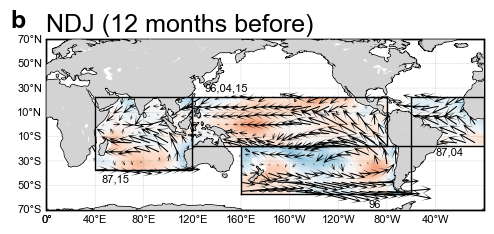

In [9]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)

map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)


map.drawcoastlines()
map.drawmapboundary(fill_color='white')


cax=plt.imshow(SP_NDJ[:,:],cmap='RdBu_r',extent=[160,300,-17.5,-57.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_NDJ[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_NDJ[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_NDJ[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)


#X,Y,U,V
X_SP_windNDJ = SP_windNDJ.longitude; Y_SP_windNDJ = SP_windNDJ.latitude
U_SP_windNDJ = SP_windNDJ.u[0]; V_SP_windNDJ = SP_windNDJ.v[0]

plt.quiver(X_SP_windNDJ[::30],Y_SP_windNDJ[::30],U_SP_windNDJ[::30,::30],V_SP_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


X_EP_windNDJ = EP_windNDJ.longitude; Y_EP_windNDJ = EP_windNDJ.latitude
U_EP_windNDJ = EP_windNDJ.u[0]; V_EP_windNDJ = EP_windNDJ.v[0]

plt.quiver(X_EP_windNDJ[::30],Y_EP_windNDJ[::30],U_EP_windNDJ[::30,::30],V_EP_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windNDJ = EA_windNDJ.longitude; Y_EA_windNDJ = EA_windNDJ.latitude
U_EA_windNDJ = EA_windNDJ.u[0]; V_EA_windNDJ = EA_windNDJ.v[0]

plt.quiver(X_EA_windNDJ[::30],Y_EA_windNDJ[::30],U_EA_windNDJ[::30,::30],V_EA_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windNDJ = IO_windNDJ.longitude; Y_IO_windNDJ = IO_windNDJ.latitude
U_IO_windNDJ = IO_windNDJ.u[0]; V_IO_windNDJ = IO_windNDJ.v[0]

plt.quiver(X_IO_windNDJ[::30],Y_IO_windNDJ[::30],U_IO_windNDJ[::30,::30],V_IO_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


plt.text(265,-68 , "96", fontsize=8, color = 'black',zorder=7)
a= [ 160,   300,  300,   160, 160]
b = [  -57.5,  -57.5,    -17.5,   -17.5, -57.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,28 , "96,04,15", fontsize=8, color = 'black',zorder=7)
a= [  120,   280,   280,   120, 120]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "87,04", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "87,15", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "b", fontsize=18, color = 'black', weight='bold')
plt.title('NDJ (12 months before) ',fontsize=18, loc='left')

plt.tight_layout()
plt.savefig(outdir+'Warm NDJ'+'.png',bbox_inches='tight')
plt.show()

# 2. Warm FMA

In [10]:
# == seasonal mean >> SP FMA
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1996
yend=1996
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA = anmFMA.sel(lat=slice(-17.5,-57.5), lon=slice(160, 300))

SP_FMA=anmFMA.mean('time')
SP_FMA_warm=SP_FMA


# == seasonal mean >> EP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1996
yend=1996
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_96 = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

ystr=2004
yend=2004
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_04 = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))


ystr=2015
yend=2015
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_15 = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

anmFMA = xr.concat([anmFMA_96,anmFMA_04, anmFMA_15],dim='time')

EP_FMA=anmFMA.mean('time')
EP_FMA_warm=EP_FMA

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1987
yend=1987
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_87 = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))


ystr=2004
yend=2004
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_04 = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))

anmFMA = xr.concat([anmFMA_87,anmFMA_04],dim='time')

EA_FMA=anmFMA.mean('time')
EA_FMA_warm=EA_FMA

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1987
yend=1987
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_87 = anmFMA.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))


ystr=2015
yend=2015
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_15 = anmFMA.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

anmFMA = xr.concat([anmFMA_87,anmFMA_15],dim='time')

IO_FMA=anmFMA.mean('time')
IO_FMA_warm=IO_FMA

In [11]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

ystr=1996
yend=1996
windFMA=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))


SP_windFMA = windFMA.sel(latitude=slice(-17.5,-57.5), longitude=slice(160, 300))
SP_windFMA_warm = SP_windFMA
print(SP_windFMA)


ystr=1996
yend=1996
windFMA_96=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

ystr=2004
yend=2004
windFMA_04=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

ystr=2015
yend=2015
windFMA_15=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

windFMA = xr.concat([windFMA_96,windFMA_04,windFMA_15], dim='time')
EP_windFMA = windFMA.sel(latitude=slice(22.5, -17.5), longitude=slice(120, 280))
EP_windFMA_warm = EP_windFMA
print(EP_windFMA)


ystr=1987
yend=1987
windFMA_87=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

ystr=2004
yend=2004
windFMA_04=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

windFMA = xr.concat([windFMA_87,windFMA_04], dim='time')
EA_windFMA = windFMA.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windFMA_warm = EA_windFMA
print(EA_windFMA)


ystr=1987
yend=1987
windFMA_87=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

ystr=2015
yend=2015
windFMA_15=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
windFMA = xr.concat([windFMA_87,windFMA_15], dim='time')

IO_windFMA = windFMA.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windFMA_warm = IO_windFMA
print(IO_windFMA)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1996-02-01 1996-03-01 1996-04-01
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 641, latitude: 161, time: 9)
Coordinates:
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 279.5 279.8 280.0
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 1996-02-01 1996-03-01 ... 2015-04-01
Data variables:
    u          (time, latitude, longitude) float32 -0.717

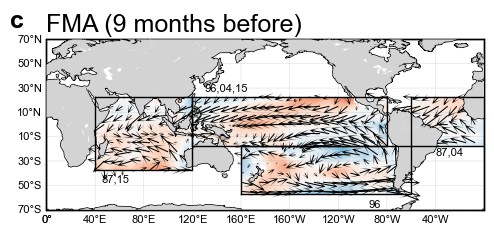

In [12]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)

map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)


map.drawcoastlines()
map.drawmapboundary(fill_color='white')


cax=plt.imshow(SP_FMA[:,:],cmap='RdBu_r',extent=[160,300,-17.5,-57.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_FMA[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_FMA[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_FMA[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)


#X,Y,U,V
X_SP_windFMA = SP_windFMA.longitude; Y_SP_windFMA = SP_windFMA.latitude
U_SP_windFMA = SP_windFMA.u[0]; V_SP_windFMA = SP_windFMA.v[0]

plt.quiver(X_SP_windFMA[::30],Y_SP_windFMA[::30],U_SP_windFMA[::30,::30],V_SP_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


X_EP_windFMA = EP_windFMA.longitude; Y_EP_windFMA = EP_windFMA.latitude
U_EP_windFMA = EP_windFMA.u[0]; V_EP_windFMA = EP_windFMA.v[0]

plt.quiver(X_EP_windFMA[::30],Y_EP_windFMA[::30],U_EP_windFMA[::30,::30],V_EP_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windFMA = EA_windFMA.longitude; Y_EA_windFMA = EA_windFMA.latitude
U_EA_windFMA = EA_windFMA.u[0]; V_EA_windFMA = EA_windFMA.v[0]

plt.quiver(X_EA_windFMA[::30],Y_EA_windFMA[::30],U_EA_windFMA[::30,::30],V_EA_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windFMA = IO_windFMA.longitude; Y_IO_windFMA = IO_windFMA.latitude
U_IO_windFMA = IO_windFMA.u[0]; V_IO_windFMA = IO_windFMA.v[0]

plt.quiver(X_IO_windFMA[::30],Y_IO_windFMA[::30],U_IO_windFMA[::30,::30],V_IO_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


plt.text(265,-68 , "96", fontsize=8, color = 'black',zorder=7)
a= [ 160,   300,  300,   160, 160]
b = [  -57.5,  -57.5,    -17.5,   -17.5, -57.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,28 , "96,04,15", fontsize=8, color = 'black',zorder=7)
a= [  120,   280,   280,   120, 120]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "87,04", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "87,15", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)


plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "c", fontsize=18, color = 'black', weight='bold')
plt.title('FMA (9 months before) ',fontsize=18, loc='left')


plt.tight_layout()
plt.savefig(outdir+'Warm FMA'+'.png',bbox_inches='tight')
plt.show()

# 3. warm MJJ

In [13]:
# == seasonal mean >> SP MJJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1996
yend=1996
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ = anmMJJ.sel(lat=slice(-17.5,-57.5), lon=slice(160, 300))

SP_MJJ=anmMJJ.mean('time')
SP_MJJ_warm=SP_MJJ

# == seasonal mean >> EP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1996
yend=1996
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_96 = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

ystr=2004
yend=2004
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_04 = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))


ystr=2015
yend=2015
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_15 = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

anmMJJ = xr.concat([anmMJJ_96,anmMJJ_04, anmMJJ_15],dim='time')

EP_MJJ=anmMJJ.mean('time')
EP_MJJ_warm=EP_MJJ

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1987
yend=1987
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_87 = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))


ystr=2004
yend=2004
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_04 = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))

anmMJJ = xr.concat([anmMJJ_87,anmMJJ_04],dim='time')

EA_MJJ=anmMJJ.mean('time')
EA_MJJ_warm=EA_MJJ

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1987
yend=1987
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_87 = anmMJJ.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))


ystr=2015
yend=2015
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_15 = anmMJJ.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

anmMJJ = xr.concat([anmMJJ_87,anmMJJ_15],dim='time')

IO_MJJ=anmMJJ.mean('time')
IO_MJJ_warm=IO_MJJ

In [14]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

ystr=1996
yend=1996
windMJJ=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))


SP_windMJJ = windMJJ.sel(latitude=slice(-17.5,-57.5), longitude=slice(160, 300))
SP_windMJJ_warm=SP_windMJJ
print(SP_windMJJ)

ystr=1996
yend=1996
windMJJ_96=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

ystr=2004
yend=2004
windMJJ_04=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

ystr=2015
yend=2015
windMJJ_15=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

windMJJ = xr.concat([windMJJ_96,windMJJ_04,windMJJ_15], dim='time')

EP_windMJJ = windMJJ.sel(latitude=slice(22.5, -17.5), longitude=slice(120, 280))
EP_windMJJ_warm=EP_windMJJ
print(EP_windMJJ)


ystr=1987
yend=1987
windMJJ_87=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

ystr=2004
yend=2004
windMJJ_04=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

windMJJ = xr.concat([windMJJ_87,windMJJ_04], dim='time')
EA_windMJJ = windMJJ.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windMJJ_warm=EA_windMJJ
print(EA_windMJJ)



ystr=1987
yend=1987
windMJJ_87=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

ystr=2015
yend=2015
windMJJ_15=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
windMJJ = xr.concat([windMJJ_87,windMJJ_15], dim='time')

IO_windMJJ = windMJJ.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windMJJ_warm=IO_windMJJ
print(IO_windMJJ)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1996-05-01 1996-06-01 1996-07-01
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 641, latitude: 161, time: 9)
Coordinates:
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 279.5 279.8 280.0
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 1996-05-01 1996-06-01 ... 2015-07-01
Data variables:
    u          (time, latitude, longitude) float32 0.0674

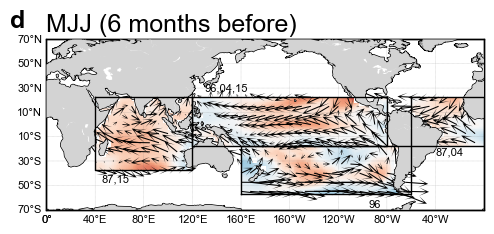

In [15]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)

map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)

map.drawcoastlines()
map.drawmapboundary(fill_color='white')


cax=plt.imshow(SP_MJJ[:,:],cmap='RdBu_r',extent=[160,300,-17.5,-57.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_MJJ[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_MJJ[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_MJJ[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)


#X,Y,U,V
X_SP_windMJJ = SP_windMJJ.longitude; Y_SP_windMJJ = SP_windMJJ.latitude
U_SP_windMJJ = SP_windMJJ.u[0]; V_SP_windMJJ = SP_windMJJ.v[0]

plt.quiver(X_SP_windMJJ[::30],Y_SP_windMJJ[::30],U_SP_windMJJ[::30,::30],V_SP_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


X_EP_windMJJ = EP_windMJJ.longitude; Y_EP_windMJJ = EP_windMJJ.latitude
U_EP_windMJJ = EP_windMJJ.u[0]; V_EP_windMJJ = EP_windMJJ.v[0]

plt.quiver(X_EP_windMJJ[::30],Y_EP_windMJJ[::30],U_EP_windMJJ[::30,::30],V_EP_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windMJJ = EA_windMJJ.longitude; Y_EA_windMJJ = EA_windMJJ.latitude
U_EA_windMJJ = EA_windMJJ.u[0]; V_EA_windMJJ = EA_windMJJ.v[0]

plt.quiver(X_EA_windMJJ[::30],Y_EA_windMJJ[::30],U_EA_windMJJ[::30,::30],V_EA_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windMJJ = IO_windMJJ.longitude; Y_IO_windMJJ = IO_windMJJ.latitude
U_IO_windMJJ = IO_windMJJ.u[0]; V_IO_windMJJ = IO_windMJJ.v[0]

plt.quiver(X_IO_windMJJ[::30],Y_IO_windMJJ[::30],U_IO_windMJJ[::30,::30],V_IO_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


plt.text(265,-68 , "96", fontsize=8, color = 'black',zorder=7)
a= [ 160,   300,  300,   160, 160]
b = [  -57.5,  -57.5,    -17.5,   -17.5, -57.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,28 , "96,04,15", fontsize=8, color = 'black',zorder=7)
a= [  120,   280,   280,   120, 120]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "87,04", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "87,15", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)


plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "d", fontsize=18, color = 'black', weight='bold')
plt.title('MJJ (6 months before) ',fontsize=18, loc='left')

plt.tight_layout()
plt.savefig(outdir+'Warm MJJ'+'.png',bbox_inches='tight')
plt.show()

# 4. warm ASO

In [16]:
# == seasonal mean >> SP MJJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1996
yend=1996
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO = anmASO.sel(lat=slice(-17.5,-57.5), lon=slice(160, 300))

SP_ASO=anmASO.mean('time')
SP_ASO_warm=SP_ASO

# == seasonal mean >> EP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=1996
yend=1996
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_96 = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

ystr=2004
yend=2004
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_04 = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))


ystr=2015
yend=2015
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_15 = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

anmASO = xr.concat([anmASO_96,anmASO_04, anmASO_15],dim='time')

EP_ASO=anmASO.mean('time')
EP_ASO_warm=EP_ASO

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1987
yend=1987
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_87 = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))


ystr=2004
yend=2004
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_04 = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))

anmASO = xr.concat([anmASO_87,anmASO_04],dim='time')


EA_ASO=anmASO.mean('time')
EA_ASO_warm=EA_ASO

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1987
yend=1987
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_87 = anmASO.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))


ystr=2015
yend=2015
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_15 = anmASO.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

anmASO = xr.concat([anmASO_87,anmASO_15],dim='time')

IO_ASO=anmASO.mean('time')
IO_ASO_warm=IO_ASO

In [17]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

ystr=1996
yend=1996
windASO=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))


SP_windASO = windASO.sel(latitude=slice(-17.5,-57.5), longitude=slice(160, 300))
SP_windASO_warm = SP_windASO
print(SP_windASO)



ystr=1996
yend=1996
windASO_96=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

ystr=2004
yend=2004
windASO_04=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

ystr=2015
yend=2015
windASO_15=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

windASO = xr.concat([windASO_96,windASO_04,windASO_15], dim='time')

EP_windASO = windASO.sel(latitude=slice(22.5, -17.5), longitude=slice(120, 280))
EP_windASO_warm = EP_windASO
print(EP_windASO)


ystr=1987
yend=1987
windASO_87=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

ystr=2004
yend=2004
windASO_04=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

windASO = xr.concat([windASO_87,windASO_04], dim='time')
EA_windASO = windASO.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windASO_warm = EA_windASO
print(EA_windASO)



ystr=1987
yend=1987
windASO_87=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

ystr=2015
yend=2015
windASO_15=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
windASO = xr.concat([windASO_87,windASO_15], dim='time')

IO_windASO = windASO.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windASO_warm = IO_windASO
print(IO_windASO)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1996-08-01 1996-09-01 1996-10-01
Data variables:
    u          (time, latitude, longitude) float32 ...
    v          (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 641, latitude: 161, time: 9)
Coordinates:
  * longitude  (longitude) float32 120.0 120.2 120.5 120.8 ... 279.5 279.8 280.0
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 1996-08-01 1996-09-01 ... 2015-10-01
Data variables:
    u          (time, latitude, longitude) float32 1.051 

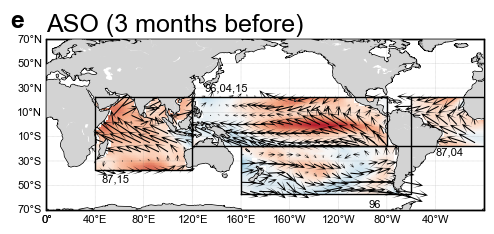

In [18]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)
map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)

map.drawcoastlines()
map.drawmapboundary(fill_color='white')


cax=plt.imshow(SP_ASO[:,:],cmap='RdBu_r',extent=[160,300,-17.5,-57.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_ASO[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_ASO[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_ASO[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)


#X,Y,U,V
X_SP_windASO = SP_windASO.longitude; Y_SP_windASO = SP_windASO.latitude
U_SP_windASO = SP_windASO.u[0]; V_SP_windASO = SP_windASO.v[0]

plt.quiver(X_SP_windASO[::30],Y_SP_windASO[::30],U_SP_windASO[::30,::30],V_SP_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


X_EP_windASO = EP_windASO.longitude; Y_EP_windASO = EP_windASO.latitude
U_EP_windASO = EP_windASO.u[0]; V_EP_windASO = EP_windASO.v[0]

plt.quiver(X_EP_windASO[::30],Y_EP_windASO[::30],U_EP_windASO[::30,::30],V_EP_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windASO = EA_windASO.longitude; Y_EA_windASO = EA_windASO.latitude
U_EA_windASO = EA_windASO.u[0]; V_EA_windASO = EA_windASO.v[0]

plt.quiver(X_EA_windASO[::30],Y_EA_windASO[::30],U_EA_windASO[::30,::30],V_EA_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windASO = IO_windASO.longitude; Y_IO_windASO = IO_windASO.latitude
U_IO_windASO = IO_windASO.u[0]; V_IO_windASO = IO_windASO.v[0]

plt.quiver(X_IO_windASO[::30],Y_IO_windASO[::30],U_IO_windASO[::30,::30],V_IO_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')


plt.text(265,-68 , "96", fontsize=8, color = 'black',zorder=7)
a= [ 160,   300,  300,   160, 160]
b = [  -57.5,  -57.5,    -17.5,   -17.5, -57.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,28 , "96,04,15", fontsize=8, color = 'black',zorder=7)
a= [  120,   280,   280,   120, 120]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "87,04", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "87,15", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)


plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "e", fontsize=18, color = 'black', weight='bold')
plt.title('ASO (3 months before) ',fontsize=18, loc='left')

plt.tight_layout()
plt.savefig(outdir+'Warm ASO'+'.png',bbox_inches='tight')
plt.show()


# 5. Cool NDJ

In [19]:
# == seasonal mean >> SP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1998
yend=1999
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_99 = anmNDJ.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

ystr=2020
yend=2021
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_21 = anmNDJ.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

anmNDJ = xr.concat([anmNDJ_99, anmNDJ_21],dim='time')
SP_NDJ=anmNDJ.mean('time')
SP_NDJ_cool=SP_NDJ

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2007
yend=2008
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))
EA_NDJ=anmNDJ.mean('time')
EA_NDJ_cool=EA_NDJ

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2011
yend=2012
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ = anmNDJ.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

IO_NDJ=anmNDJ.mean('time')
IO_NDJ_cool=IO_NDJ

# == seasonal mean >> NP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1990
yend=1991
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_91 = anmNDJ.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=1998
yend=1999
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_99 = anmNDJ.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=2020
yend=2021
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ_21 = anmNDJ.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

anmNDJ = xr.concat([anmNDJ_91,anmNDJ_99, anmNDJ_21],dim='time')

NP_NDJ=anmNDJ.mean('time')
NP_NDJ_cool=NP_NDJ

# == seasonal mean >> EP NDJ

ystr=1990
yend=1991
anmNDJ=anmS.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
anmNDJ = anmNDJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))


EP_NDJ=anmNDJ.mean('time')
EP_NDJ_cool=EP_NDJ

In [20]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

##SP
ystr=1998
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))


ystr=2020
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

SP_windNDJ = xr.concat([wind_99,wind_21], dim='time')

SP_windNDJ = SP_windNDJ.sel(latitude=slice(-17.5, -57.5), longitude=slice(160, 300))
SP_windNDJ_cool=SP_windNDJ
print(SP_windNDJ)


##EA
ystr=2007
yend=2008
windNDJ=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

EA_windNDJ = windNDJ.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windNDJ_cool=EA_windNDJ
print(EA_windNDJ)

##IO
ystr=2011
yend=2012
windNDJ=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))


IO_windNDJ = windNDJ.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windNDJ_cool=IO_windNDJ
print(IO_windNDJ)

##NP
ystr=1990
yend=1991
wind_91=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
ystr=1998
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))
ystr=2020
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))

NP_windNDJ = xr.concat([wind_91,wind_99,wind_21], dim='time')
NP_windNDJ = NP_windNDJ.sel(latitude=slice(62.5,22.5), longitude=slice(120, 260))
NP_windNDJ_cool=NP_windNDJ
print(NP_windNDJ)

##EP
ystr=2011
yend=2012
windNDJ=wind.sel(time=slice(f'{ystr}-11-01',f'{yend}-01-01'))


EP_windNDJ = windNDJ.sel(latitude=slice(22.5,-17.5), longitude=slice(120, 280))
EP_windNDJ_cool=EP_windNDJ
print(EP_windNDJ)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 6)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1998-11-01 1998-12-01 ... 2021-01-01
Data variables:
    u          (time, latitude, longitude) float32 -2.041 -2.003 ... 11.92 11.88
    v          (time, latitude, longitude) float32 1.202 1.149 ... -0.229
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 300.0 300.2 300.5 300.8 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 2007-11-01 2007-12-01 2008-01-01
Data variables:
    u       

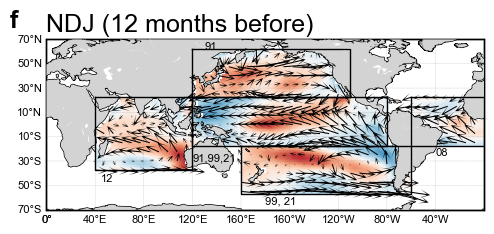

In [21]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)

map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)

map.drawcoastlines()
map.drawmapboundary(fill_color='white')

cax=plt.imshow(SP_NDJ[:,:],cmap='RdBu_r',extent=[160,300,-57.5, -17.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_NDJ[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_NDJ[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(NP_NDJ[:,:],cmap='RdBu_r',extent=[120,260,22.5,62.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_NDJ[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)

#X,Y,U,V
X_SP_windNDJ = SP_windNDJ.longitude; Y_SP_windNDJ = SP_windNDJ.latitude
U_SP_windNDJ = SP_windNDJ.u[0]; V_SP_windNDJ = SP_windNDJ.v[0]

plt.quiver(X_SP_windNDJ[::30],Y_SP_windNDJ[::30],U_SP_windNDJ[::30,::30],V_SP_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windNDJ = EA_windNDJ.longitude; Y_EA_windNDJ = EA_windNDJ.latitude
U_EA_windNDJ = EA_windNDJ.u[0]; V_EA_windNDJ = EA_windNDJ.v[0]

plt.quiver(X_EA_windNDJ[::30],Y_EA_windNDJ[::30],U_EA_windNDJ[::30,::30],V_EA_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windNDJ = IO_windNDJ.longitude; Y_IO_windNDJ = IO_windNDJ.latitude
U_IO_windNDJ = IO_windNDJ.u[0]; V_IO_windNDJ = IO_windNDJ.v[0]

plt.quiver(X_IO_windNDJ[::30],Y_IO_windNDJ[::30],U_IO_windNDJ[::30,::30],V_IO_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_NP_windNDJ = NP_windNDJ.longitude; Y_NP_windNDJ = NP_windNDJ.latitude
U_NP_windNDJ = NP_windNDJ.u[0]; V_NP_windNDJ = NP_windNDJ.v[0]

plt.quiver(X_NP_windNDJ[::30],Y_NP_windNDJ[::30],U_NP_windNDJ[::30,::30],V_NP_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EP_windNDJ = EP_windNDJ.longitude; Y_EP_windNDJ = EP_windNDJ.latitude
U_EP_windNDJ = EP_windNDJ.u[0]; V_EP_windNDJ = EP_windNDJ.v[0]

plt.quiver(X_EP_windNDJ[::30],Y_EP_windNDJ[::30],U_EP_windNDJ[::30,::30],V_EP_windNDJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')




plt.text(180,-65 , "99, 21", fontsize=8, color = 'black',zorder=7)
a= [  160,   300,   300,   160, 160]
b = [  -17.5,   -17.5,    -57.5,   -57.5, -17.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "08", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "12", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(120,-30 , "91,99,21", fontsize=8, color = 'black',zorder=7)
a= [ 120,   250,  250,   120, 120]
b = [  62.5,  62.5,    22.5,   22.5, 62.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,62 , "91", fontsize=8, color = 'black',zorder=7)
a= [ 120,   280,  280,   120, 120]
b = [  22.5,  22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "f", fontsize=18, color = 'black', weight='bold')
plt.title('NDJ (12 months before) ',fontsize=18, loc='left')


plt.tight_layout()
plt.savefig(outdir+'Cool NDJ'+'.png',bbox_inches='tight')
plt.show()

# 6. Cool FMA

In [22]:
# == seasonal mean >> SP FMA
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1999
yend=1999
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_99 = anmFMA.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

ystr=2021
yend=2021
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_21 = anmFMA.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

anmFMA = xr.concat([anmFMA_99, anmFMA_21],dim='time')
SP_FMA=anmFMA.mean('time')
SP_FMA_cool=SP_FMA


# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2008
yend=2008
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))
EA_FMA=anmFMA.mean('time')
EA_FMA_cool=EA_FMA

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2012
yend=2012
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA = anmFMA.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

IO_FMA=anmFMA.mean('time')
IO_FMA_cool=IO_FMA


# == seasonal mean >> NP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1991
yend=1991
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_91 = anmFMA.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=1999
yend=1999
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_99 = anmFMA.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=2021
yend=2021
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA_21 = anmFMA.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

anmFMA = xr.concat([anmFMA_91,anmFMA_99, anmFMA_21],dim='time')

NP_FMA=anmFMA.mean('time')
NP_FMA_cool=NP_FMA

# == seasonal mean >> EP NDJ

ystr=1991
yend=1991
anmFMA=anmS.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
anmFMA = anmFMA.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

EP_FMA=anmFMA.mean('time')
EP_FMA_cool=EP_FMA

In [23]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

##SP

ystr=1999
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))


ystr=2021
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

SP_windFMA = xr.concat([wind_99,wind_21], dim='time')

SP_windFMA = SP_windFMA.sel(latitude=slice(-17.5, -57.5), longitude=slice(160, 300))
SP_windFMA_cool=SP_windFMA
print(SP_windFMA)


##EA
ystr=2008
yend=2008
windFMA=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

EA_windFMA = windFMA.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windFMA_cool=EA_windFMA
print(EA_windFMA)

##IO
ystr=2012
yend=2012
windFMA=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))


IO_windFMA = windFMA.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windFMA_cool=IO_windFMA
print(IO_windFMA)


##NP
ystr=1991
yend=1991
wind_91=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
ystr=1999
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))
ystr=2021
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))

NP_windFMA = xr.concat([wind_91,wind_99,wind_21], dim='time')
NP_windFMA = NP_windFMA.sel(latitude=slice(62.5,22.5), longitude=slice(120, 260))
NP_windFMA_cool=NP_windFMA
print(NP_windFMA)

##EP
ystr=2012
yend=2012
windFMA=wind.sel(time=slice(f'{ystr}-02-01',f'{yend}-04-01'))


EP_windFMA = windFMA.sel(latitude=slice(22.5,-17.5), longitude=slice(120, 280))
EP_windFMA_cool=EP_windFMA
print(EP_windFMA)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 6)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1999-02-01 1999-03-01 ... 2021-04-01
Data variables:
    u          (time, latitude, longitude) float32 1.906 1.905 ... 11.73 11.81
    v          (time, latitude, longitude) float32 0.09073 0.01466 ... -1.093
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 300.0 300.2 300.5 300.8 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 2008-02-01 2008-03-01 2008-04-01
Data variables:
    u     

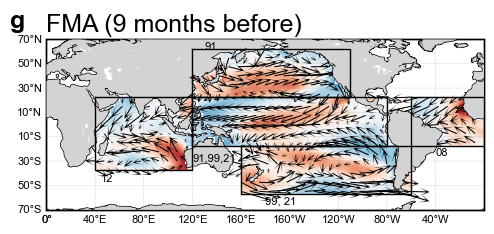

In [24]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)
map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)
map.drawcoastlines()
map.drawmapboundary(fill_color='white')

cax=plt.imshow(SP_FMA[:,:],cmap='RdBu_r',extent=[160,300,-57.5, -17.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_FMA[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_FMA[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(NP_FMA[:,:],cmap='RdBu_r',extent=[120,260,22.5,62.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_FMA[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)

#X,Y,U,V
X_SP_windFMA = SP_windFMA.longitude; Y_SP_windFMA = SP_windFMA.latitude
U_SP_windFMA = SP_windFMA.u[0]; V_SP_windFMA = SP_windFMA.v[0]

plt.quiver(X_SP_windFMA[::30],Y_SP_windFMA[::30],U_SP_windFMA[::30,::30],V_SP_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windFMA = EA_windFMA.longitude; Y_EA_windFMA = EA_windFMA.latitude
U_EA_windFMA = EA_windFMA.u[0]; V_EA_windFMA = EA_windFMA.v[0]

plt.quiver(X_EA_windFMA[::30],Y_EA_windFMA[::30],U_EA_windFMA[::30,::30],V_EA_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windFMA = IO_windFMA.longitude; Y_IO_windFMA = IO_windFMA.latitude
U_IO_windFMA = IO_windFMA.u[0]; V_IO_windFMA = IO_windFMA.v[0]

plt.quiver(X_IO_windFMA[::30],Y_IO_windFMA[::30],U_IO_windFMA[::30,::30],V_IO_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_NP_windFMA = NP_windFMA.longitude; Y_NP_windFMA = NP_windFMA.latitude
U_NP_windFMA = NP_windFMA.u[0]; V_NP_windFMA = NP_windFMA.v[0]

plt.quiver(X_NP_windFMA[::30],Y_NP_windFMA[::30],U_NP_windFMA[::30,::30],V_NP_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EP_windFMA = EP_windFMA.longitude; Y_EP_windFMA = EP_windFMA.latitude
U_EP_windFMA = EP_windFMA.u[0]; V_EP_windFMA = EP_windFMA.v[0]

plt.quiver(X_EP_windFMA[::30],Y_EP_windFMA[::30],U_EP_windFMA[::30,::30],V_EP_windFMA[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

plt.text(180,-65 , "99, 21", fontsize=8, color = 'black',zorder=7)
a= [  160,   300,   300,   160, 160]
b = [  -17.5,   -17.5,    -57.5,   -57.5, -17.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "08", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "12", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(120,-30 , "91,99,21", fontsize=8, color = 'black',zorder=7)
a= [ 120,   250,  250,   120, 120]
b = [  62.5,  62.5,    22.5,   22.5, 62.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,62 , "91", fontsize=8, color = 'black',zorder=7)
a= [ 120,   280,  280,   120, 120]
b = [  22.5,  22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "g", fontsize=18, color = 'black', weight='bold')
plt.title('FMA (9 months before) ',fontsize=18, loc='left')

plt.tight_layout()
plt.savefig(outdir+'Cool FMA'+'.png',bbox_inches='tight')
plt.show()

# 7. Cool MJJ

In [25]:
# == seasonal mean >> SP FMA
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1999
yend=1999
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_99 = anmMJJ.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

ystr=2021
yend=2021
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_21 = anmMJJ.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

anmMJJ = xr.concat([anmMJJ_99, anmMJJ_21],dim='time')
SP_MJJ=anmMJJ.mean('time')
SP_MJJ_cool=SP_MJJ

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2008
yend=2008
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))
EA_MJJ=anmMJJ.mean('time')
EA_MJJ_cool=EA_MJJ

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2012
yend=2012
anmMJJ =anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ = anmMJJ.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

IO_MJJ=anmMJJ.mean('time')
IO_MJJ_cool=IO_MJJ

# == seasonal mean >> NP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1991
yend=1991
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_91 = anmMJJ.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=1999
yend=1999
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_99 = anmMJJ.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=2021
yend=2021
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ_21 = anmMJJ.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

anmMJJ = xr.concat([anmMJJ_91,anmMJJ_99, anmMJJ_21],dim='time')

NP_MJJ=anmMJJ.mean('time')
NP_MJJ_cool=NP_MJJ

# == seasonal mean >> EP NDJ

ystr=1991
yend=1991
anmMJJ=anmS.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
anmMJJ = anmMJJ.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

EP_MJJ=anmMJJ.mean('time')
EP_MJJ_cool=EP_MJJ

In [26]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

##SP
ystr=1999
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))


ystr=2021
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

SP_windMJJ = xr.concat([wind_99,wind_21], dim='time')

SP_windMJJ = SP_windMJJ.sel(latitude=slice(-17.5, -57.5), longitude=slice(160, 300))
SP_windMJJ_cool=SP_windMJJ
print(SP_windMJJ)


##EA
ystr=2008
yend=2008
windMJJ=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

EA_windMJJ = windMJJ.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windMJJ_cool=EA_windMJJ
print(EA_windMJJ)

##IO
ystr=2012
yend=2012
windMJJ=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))


IO_windMJJ = windMJJ.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windMJJ_cool=IO_windMJJ
print(IO_windMJJ)


##NP
ystr=1991
yend=1991
wind_91=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
ystr=1999
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))
ystr=2021
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))

NP_windMJJ = xr.concat([wind_91,wind_99,wind_21], dim='time')
NP_windMJJ = NP_windMJJ.sel(latitude=slice(62.5,22.5), longitude=slice(120, 260))
NP_windMJJ_cool=NP_windMJJ
print(NP_windMJJ)

##EP
ystr=2012
yend=2012
windMJJ=wind.sel(time=slice(f'{ystr}-05-01',f'{yend}-07-01'))


EP_windMJJ = windMJJ.sel(latitude=slice(22.5,-17.5), longitude=slice(120, 280))
EP_windMJJ_cool=EP_windMJJ
print(EP_windMJJ)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 6)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1999-05-01 1999-06-01 ... 2021-07-01
Data variables:
    u          (time, latitude, longitude) float32 -7.06 -6.991 ... 5.448 5.394
    v          (time, latitude, longitude) float32 2.154 1.947 ... -3.809 -3.741
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 300.0 300.2 300.5 300.8 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 2008-05-01 2008-06-01 2008-07-01
Data variables:
    u 

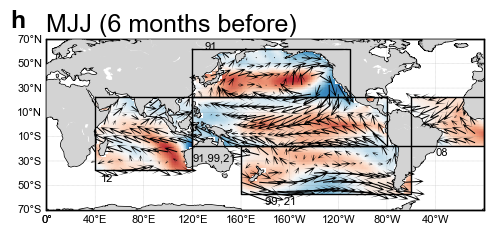

In [27]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)

map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)
map.drawcoastlines()
map.drawmapboundary(fill_color='white')

cax=plt.imshow(SP_MJJ[:,:],cmap='RdBu_r',extent=[160,300,-57.5, -17.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_MJJ[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_MJJ[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(NP_MJJ[:,:],cmap='RdBu_r',extent=[120,260,22.5,62.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_MJJ[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)

#X,Y,U,V
X_SP_windMJJ = SP_windMJJ.longitude; Y_SP_windMJJ = SP_windMJJ.latitude
U_SP_windMJJ = SP_windMJJ.u[0]; V_SP_windMJJ = SP_windMJJ.v[0]

plt.quiver(X_SP_windMJJ[::30],Y_SP_windMJJ[::30],U_SP_windMJJ[::30,::30],V_SP_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windMJJ = EA_windMJJ.longitude; Y_EA_windMJJ = EA_windMJJ.latitude
U_EA_windMJJ = EA_windMJJ.u[0]; V_EA_windMJJ = EA_windMJJ.v[0]

plt.quiver(X_EA_windMJJ[::30],Y_EA_windMJJ[::30],U_EA_windMJJ[::30,::30],V_EA_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windMJJ = IO_windMJJ.longitude; Y_IO_windMJJ = IO_windMJJ.latitude
U_IO_windMJJ = IO_windMJJ.u[0]; V_IO_windMJJ = IO_windMJJ.v[0]

plt.quiver(X_IO_windMJJ[::30],Y_IO_windMJJ[::30],U_IO_windMJJ[::30,::30],V_IO_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_NP_windMJJ = NP_windMJJ.longitude; Y_NP_windMJJ = NP_windMJJ.latitude
U_NP_windMJJ = NP_windMJJ.u[0]; V_NP_windMJJ = NP_windMJJ.v[0]

plt.quiver(X_NP_windMJJ[::30],Y_NP_windMJJ[::30],U_NP_windMJJ[::30,::30],V_NP_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EP_windMJJ = EP_windMJJ.longitude; Y_EP_windMJJ = EP_windMJJ.latitude
U_EP_windMJJ = EP_windMJJ.u[0]; V_EP_windMJJ = EP_windMJJ.v[0]

plt.quiver(X_EP_windMJJ[::30],Y_EP_windMJJ[::30],U_EP_windMJJ[::30,::30],V_EP_windMJJ[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

plt.text(180,-65 , "99, 21", fontsize=8, color = 'black',zorder=7)
a= [  160,   300,   300,   160, 160]
b = [  -17.5,   -17.5,    -57.5,   -57.5, -17.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "08", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "12", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(120,-30 , "91,99,21", fontsize=8, color = 'black',zorder=7)
a= [ 120,   250,  250,   120, 120]
b = [  62.5,  62.5,    22.5,   22.5, 62.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,62 , "91", fontsize=8, color = 'black',zorder=7)
a= [ 120,   280,  280,   120, 120]
b = [  22.5,  22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "h", fontsize=18, color = 'black', weight='bold')
plt.title('MJJ (6 months before) ',fontsize=18, loc='left')

plt.tight_layout()
plt.savefig(outdir+'Cool MJJ'+'.png',bbox_inches='tight')
plt.show()


# 8. Cool ASO

In [28]:
# == seasonal mean >> SP FMA
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1999
yend=1999
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_99 = anmASO.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

ystr=2021
yend=2021
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_21 = anmASO.sel(lat=slice(-17.5, -57.5), lon=slice(160, 300))

anmASO = xr.concat([anmASO_99, anmASO_21],dim='time')
SP_ASO=anmASO.mean('time')
SP_ASO_cool=SP_ASO

# == seasonal mean >> EA NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2008
yend=2008
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(300, 360))
EA_ASO=anmASO.mean('time')
EA_ASO_cool=EA_ASO

# == seasonal mean >> IO NDJ
anmS = anm.rolling(time=3, center=True).mean('time')
ystr=2012
yend=2012
anmASO =anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO = anmASO.sel(lat=slice(22.5,-37.5), lon=slice(40, 120))

IO_ASO=anmASO.mean('time')
IO_ASO_cool=IO_ASO

# == seasonal mean >> NP NDJ
anmS = anm.rolling(time=3, center=True).mean('time')

ystr=1991
yend=1991
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_91 = anmASO.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=1999
yend=1999
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_99 = anmASO.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

ystr=2021
yend=2021
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO_21 = anmASO.sel(lat=slice(62.5,22.5), lon=slice(120, 260))

anmASO = xr.concat([anmASO_91,anmASO_99, anmASO_21],dim='time')

NP_ASO=anmASO.mean('time')
NP_ASO_cool=NP_ASO

# == seasonal mean >> EP NDJ

ystr=1991
yend=1991
anmASO=anmS.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
anmASO = anmASO.sel(lat=slice(22.5,-17.5), lon=slice(120, 280))

EP_ASO=anmASO.mean('time')
EP_ASO_cool=EP_ASO

In [29]:
Data = xarray.open_dataset(ifile + "ERA5_pressure.nc")
crwc = Data.variables['crwc'][:].squeeze(dim=None)
Data = Data.drop('crwc', dim = None)
wind=Data.isel(level=1)
wind

##SP

ystr=1999
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))


ystr=2021
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

SP_windASO = xr.concat([wind_99,wind_21], dim='time')

SP_windASO = SP_windASO.sel(latitude=slice(-17.5, -57.5), longitude=slice(160, 300))
SP_windASO_cool=SP_windASO
print(SP_windASO)


##EA
ystr=2008
yend=2008
windASO=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

EA_windASO = windASO.sel(latitude=slice(22.5, -17.5), longitude=slice(300, 360))
EA_windASO_cool=EA_windASO
print(EA_windASO)

##IO
ystr=2012
yend=2012
windASO=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))


IO_windASO = windASO.sel(latitude=slice(22.5,-37.5), longitude=slice(40, 120))
IO_windASO_cool=IO_windASO
print(IO_windASO)


##NP
ystr=1991
yend=1991
wind_91=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
ystr=1999
yend=1999
wind_99=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))
ystr=2021
yend=2021
wind_21=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))

NP_windASO = xr.concat([wind_91,wind_99,wind_21], dim='time')
NP_windASO = NP_windASO.sel(latitude=slice(62.5,22.5), longitude=slice(120, 260))
NP_windASO_cool=NP_windASO
print(NP_windASO)

##EP
ystr=2012
yend=2012
windASO=wind.sel(time=slice(f'{ystr}-08-01',f'{yend}-10-01'))


EP_windASO = windASO.sel(latitude=slice(22.5,-17.5), longitude=slice(120, 280))
EP_windASO_cool=EP_windASO
print(EP_windASO)

<xarray.Dataset>
Dimensions:    (longitude: 561, latitude: 161, time: 6)
Coordinates:
  * longitude  (longitude) float32 160.0 160.2 160.5 160.8 ... 299.5 299.8 300.0
  * latitude   (latitude) float32 -17.5 -17.75 -18.0 ... -57.0 -57.25 -57.5
    level      int32 925
  * time       (time) datetime64[ns] 1999-08-01 1999-09-01 ... 2021-10-01
Data variables:
    u          (time, latitude, longitude) float32 -8.248 -8.286 ... 14.2 14.13
    v          (time, latitude, longitude) float32 5.011 5.055 ... -1.709 -1.681
Attributes:
    Conventions:  CF-1.6
    history:      2023-03-14 08:32:13 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...
<xarray.Dataset>
Dimensions:    (longitude: 240, latitude: 161, time: 3)
Coordinates:
  * longitude  (longitude) float32 300.0 300.2 300.5 300.8 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 22.5 22.25 22.0 21.75 ... -17.0 -17.25 -17.5
    level      int32 925
  * time       (time) datetime64[ns] 2008-08-01 2008-09-01 2008-10-01
Data variables:
    u 

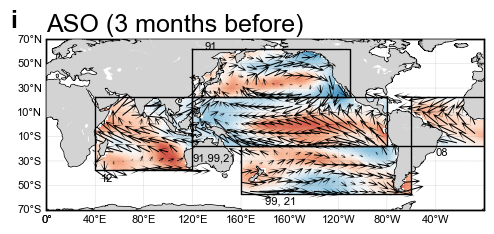

In [30]:
fig = plt.figure(figsize=(5, 10))
plt.rcParams["font.family"] = "Arial"

plt.gca().invert_yaxis()
map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)
map.drawcoastlines(linewidth=0.2)
map.drawparallels(np.arange( -90, 90,20.),labels=[1,0,0,0],fontsize=8,
                  color='grey', linewidth=0.2)
map.drawmeridians(np.arange(0,360,40.),labels=[0,0,0,1],fontsize=8,
                  color='grey', linewidth=0.2)
map.fillcontinents(color='lightgray', zorder=5)
#map.fillcontinents(color='coral',lake_color='aqua')

map.drawcoastlines()
map.drawmapboundary(fill_color='white')

cax=plt.imshow(SP_ASO[:,:],cmap='RdBu_r',extent=[160,300,-57.5, -17.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EA_ASO[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(IO_ASO[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(NP_ASO[:,:],cmap='RdBu_r',extent=[120,260,22.5,62.5], vmax = 1.5, vmin=-1.5)
cax=plt.imshow(EP_ASO[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)

#X,Y,U,V
X_SP_windASO = SP_windASO.longitude; Y_SP_windASO = SP_windASO.latitude
U_SP_windASO = SP_windASO.u[0]; V_SP_windASO = SP_windASO.v[0]

plt.quiver(X_SP_windASO[::30],Y_SP_windASO[::30],U_SP_windASO[::30,::30],V_SP_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EA_windASO = EA_windASO.longitude; Y_EA_windASO = EA_windASO.latitude
U_EA_windASO = EA_windASO.u[0]; V_EA_windASO = EA_windASO.v[0]

plt.quiver(X_EA_windASO[::30],Y_EA_windASO[::30],U_EA_windASO[::30,::30],V_EA_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_IO_windASO = IO_windASO.longitude; Y_IO_windASO = IO_windASO.latitude
U_IO_windASO = IO_windASO.u[0]; V_IO_windASO = IO_windASO.v[0]
                                                           
                                                           
plt.quiver(X_IO_windASO[::30],Y_IO_windASO[::30],U_IO_windASO[::30,::30],V_IO_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_NP_windASO = NP_windASO.longitude; Y_NP_windASO = NP_windASO.latitude
U_NP_windASO = NP_windASO.u[0]; V_NP_windASO = NP_windASO.v[0]

plt.quiver(X_NP_windASO[::30],Y_NP_windASO[::30],U_NP_windASO[::30,::30],V_NP_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')

X_EP_windASO = EP_windASO.longitude; Y_EP_windASO = EP_windASO.latitude
U_EP_windASO = EP_windASO.u[0]; V_EP_windASO = EP_windASO.v[0]

plt.quiver(X_EP_windASO[::30],Y_EP_windASO[::30],U_EP_windASO[::30,::30],V_EP_windASO[::30,::30],scale=200, color='black', 
          headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
         zorder=4, edgecolor='black')




plt.text(180,-65 , "99, 21", fontsize=8, color = 'black',zorder=7)
a= [  160,   300,   300,   160, 160]
b = [  -17.5,   -17.5,    -57.5,   -57.5, -17.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(320,-25 , "08", fontsize=8, color = 'black',zorder=7)
a= [  300,   360,   360,   300, 300]
b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(45,-47 , "12", fontsize=8, color = 'black',zorder=7)
a= [  40,   120,   120,   40, 40]
b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(120,-30 , "91,99,21", fontsize=8, color = 'black',zorder=7)
a= [ 120,   250,  250,   120, 120]
b = [  62.5,  62.5,    22.5,   22.5, 62.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.text(130,62 , "91", fontsize=8, color = 'black',zorder=7)
a= [ 120,   280,  280,   120, 120]
b = [  22.5,  22.5,    -17.5,   -17.5, 22.5]
plt.plot(a,b,'black',zorder=6,linewidth=1)

plt.rcParams["font.family"] = "Arial"
plt.text(-30,80 , "i", fontsize=18, color = 'black', weight='bold')
plt.title('ASO (3 months before) ',fontsize=18, loc='left')

plt.tight_layout()
plt.savefig(outdir+'Cool ASO'+'.png',bbox_inches='tight')
plt.show()

# Making combine plot

In [31]:
def imagemaker_warm(SP,EP,EA,IO,SP_wind,EP_wind,EA_wind,IO_wind,title,grid_space,pic_number):
    
    ax = fig.add_subplot(grid_space)

    cmap = mpl.cm.get_cmap('RdBu_r')
    levels=np.arange(-2.0,2.01,0.05)

    cax=plt.imshow(SP[:,:],cmap='RdBu_r',extent=[160,300,-17.5,-57.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(EP[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(EA[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(IO[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)


    #X,Y,U,V
    X_SP_wind = SP_wind.longitude; Y_SP_wind = SP_wind.latitude
    U_SP_wind = SP_wind.u[0]; V_SP_wind = SP_wind.v[0]

    plt.quiver(X_SP_wind[::30],Y_SP_wind[::30],U_SP_wind[::30,::30],V_SP_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')


    X_EP_wind = EP_wind.longitude; Y_EP_wind = EP_wind.latitude
    U_EP_wind = EP_wind.u[0]; V_EP_wind = EP_wind.v[0]

    plt.quiver(X_EP_wind[::30],Y_EP_wind[::30],U_EP_wind[::30,::30],V_EP_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')

    X_EA_wind = EA_wind.longitude; Y_EA_wind = EA_wind.latitude
    U_EA_wind = EA_wind.u[0]; V_EA_wind = EA_wind.v[0]

    plt.quiver(X_EA_wind[::30],Y_EA_wind[::30],U_EA_wind[::30,::30],V_EA_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')

    X_IO_wind = IO_wind.longitude; Y_IO_wind = IO_wind.latitude
    U_IO_wind = IO_wind.u[0]; V_IO_wind = IO_wind.v[0]

    plt.quiver(X_IO_wind[::30],Y_IO_wind[::30],U_IO_wind[::30,::30],V_IO_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')
    
    
    plt.text(265,-68 , "96", fontsize=8, color = 'black',zorder=7)
    a= [ 160,   300,  300,   160, 160]
    b = [  -57.5,  -57.5,    -17.5,   -17.5, -57.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(140,30 , "96,04,15", fontsize=8, color = 'black',zorder=7)
    a= [  120,   280,   280,   120, 120]
    b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(320,-30 , "87,04", fontsize=8, color = 'black',zorder=7)
    a= [  300,   360,   360,   300, 300]
    b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(45,-52 , "87,15", fontsize=8, color = 'black',zorder=7)
    a= [  40,   120,   120,   40, 40]
    b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)
    
    plt.text(-60,82 , pic_number, fontsize=14, color = 'black')
    plt.title(title,fontsize=14, loc='left')
    
    map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)
    map.drawcoastlines(linewidth=0.2)
    map.drawparallels(np.arange( -90, 90,30.),labels=[1,0,0,0],fontsize=8,
                      color='grey', linewidth=0.2)
    map.drawmeridians(np.arange(0,360,60.),labels=[0,0,0,1],fontsize=8,
                      color='grey', linewidth=0.2)
    map.fillcontinents(color='lightgray', zorder=5)
    #map.fillcontinents(color='coral',lake_color='aqua')

    map.drawcoastlines()
    map.drawmapboundary(fill_color='white')
    
    return ax, cax

In [32]:
def imagemaker_cool(SP,EA,IO,NP,EP,SP_wind,EA_wind,IO_wind,NP_wind,EP_wind,title,grid_space,pic_number):
    
    ax = fig.add_subplot(grid_space)

    cmap = mpl.cm.get_cmap('RdBu_r')
    levels=np.arange(-2.0,2.01,0.05)

    cax=plt.imshow(SP[:,:],cmap='RdBu_r',extent=[160,300,-57.5, -17.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(EA[:,:],cmap='RdBu_r',extent=[300,360,-17.5,22.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(IO[:,:],cmap='RdBu_r',extent=[40,120,-37.5,22.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(NP[:,:],cmap='RdBu_r',extent=[120,260,22.5,62.5], vmax = 1.5, vmin=-1.5)
    cax=plt.imshow(EP[:,:],cmap='RdBu_r',extent=[120,280,-17.5,22.5], vmax = 1.5, vmin=-1.5)
    
    
    #X,Y,U,V
    X_SP_wind = SP_wind.longitude; Y_SP_wind = SP_wind.latitude
    U_SP_wind = SP_wind.u[0]; V_SP_wind = SP_wind.v[0]

    plt.quiver(X_SP_wind[::30],Y_SP_wind[::30],U_SP_wind[::30,::30],V_SP_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')

    X_EA_wind = EA_wind.longitude; Y_EA_wind = EA_wind.latitude
    U_EA_wind = EA_wind.u[0]; V_EA_wind = EA_wind.v[0]

    plt.quiver(X_EA_wind[::30],Y_EA_wind[::30],U_EA_wind[::30,::30],V_EA_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')

    X_IO_wind = IO_wind.longitude; Y_IO_wind = IO_wind.latitude
    U_IO_wind = IO_wind.u[0]; V_IO_wind = IO_wind.v[0]


    plt.quiver(X_IO_wind[::30],Y_IO_wind[::30],U_IO_wind[::30,::30],V_IO_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')

    X_NP_wind = NP_wind.longitude; Y_NP_wind = NP_wind.latitude
    U_NP_wind = NP_wind.u[0]; V_NP_wind = NP_wind.v[0]

    plt.quiver(X_NP_wind[::30],Y_NP_wind[::30],U_NP_wind[::30,::30],V_NP_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')

    X_EP_wind = EP_wind.longitude; Y_EP_wind = EP_wind.latitude
    U_EP_wind = EP_wind.u[0]; V_EP_wind = EP_wind.v[0]

    plt.quiver(X_EP_wind[::30],Y_EP_wind[::30],U_EP_wind[::30,::30],V_EP_wind[::30,::30],scale=200, color='black', 
              headaxislength=3.0, headlength=9.5, headwidth=8, width=0.0024,
             zorder=4, edgecolor='black')
    
    
    
    plt.text(180,-68 , "99, 21", fontsize=8, color = 'black',zorder=7)
    a= [  160,   300,   300,   160, 160]
    b = [  -17.5,   -17.5,    -57.5,   -57.5, -17.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(320,-30 , "08", fontsize=8, color = 'black',zorder=7)
    a= [  300,   360,   360,   300, 300]
    b = [  22.5,   22.5,    -17.5,   -17.5, 22.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(45,-52 , "12", fontsize=8, color = 'black',zorder=7)
    a= [  40,   120,   120,   40, 40]
    b = [  22.5,   22.5,    -37.5,   -37.5, 22.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(120,-30 , "91,99,21", fontsize=8, color = 'black',zorder=7)
    a= [ 120,   250,  250,   120, 120]
    b = [  62.5,  62.5,    22.5,   22.5, 62.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(130,62 , "91", fontsize=8, color = 'black',zorder=7)
    a= [ 120,   280,  280,   120, 120]
    b = [  22.5,  22.5,    -17.5,   -17.5, 22.5]
    plt.plot(a,b,'black',zorder=6,linewidth=1)

    plt.text(-60,82 , pic_number, fontsize=14, color = 'black')
    plt.title(title,fontsize=14, loc='left')
    
    map = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=70, resolution='c',llcrnrlon=0, urcrnrlon=360)
    map.drawcoastlines(linewidth=0.2)
    map.drawparallels(np.arange( -90, 90,30.),labels=[1,0,0,0],fontsize=8,
                      color='grey', linewidth=0.2)
    map.drawmeridians(np.arange(0,360,60.),labels=[0,0,0,1],fontsize=8,
                      color='grey', linewidth=0.2)
    map.fillcontinents(color='lightgray', zorder=5)
    map.drawcoastlines()
    map.drawmapboundary(fill_color='white')

    return ax, cax

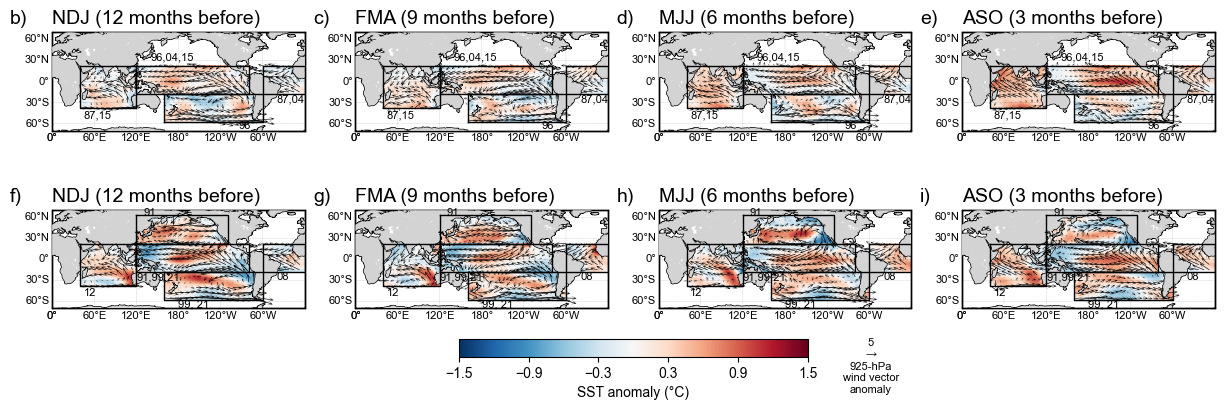

In [33]:
# plotted the multiple consecutive months of SSTA and 925-hPa wind vector anomalies (Figure 4b-i))
fig = plt.figure(figsize=(15, 5))
grid = fig.add_gridspec(ncols=4, nrows=2, hspace=0.5)


ax1, cax1 = imagemaker_warm(SP_NDJ_warm,EP_NDJ_warm,EA_NDJ_warm,IO_NDJ_warm,
                       SP_windNDJ_warm,EP_windNDJ_warm,EA_windNDJ_warm,IO_windNDJ_warm, 
                       'NDJ (12 months before)',grid[0,0],"b)")
ax2, cax2 = imagemaker_warm(SP_FMA_warm,EP_FMA_warm,EA_FMA_warm,IO_FMA_warm,
                       SP_windFMA_warm,EP_windFMA_warm,EA_windFMA_warm,IO_windFMA_warm, 
                       'FMA (9 months before)',grid[0,1],"c)")
ax3, cax3 = imagemaker_warm(SP_MJJ_warm,EP_MJJ_warm,EA_MJJ_warm,IO_MJJ_warm,
                       SP_windMJJ_warm,EP_windMJJ_warm,EA_windMJJ_warm,IO_windMJJ_warm, 
                       'MJJ (6 months before)',grid[0,2],"d)")
ax4, cax4 = imagemaker_warm(SP_ASO_warm,EP_ASO_warm,EA_ASO_warm,IO_ASO_warm,
                       SP_windASO_warm,EP_windASO_warm,EA_windASO_warm,IO_windASO_warm, 
                       'ASO (3 months before)',grid[0,3],"e)")



ax5, cax5 = imagemaker_cool(SP_NDJ_cool,EA_NDJ_cool,IO_NDJ_cool,NP_NDJ_cool,EP_NDJ_cool,
                       SP_windNDJ_cool,EA_windNDJ_cool,IO_windNDJ_cool,NP_windNDJ_cool,EP_windNDJ_cool, 
                       'NDJ (12 months before)',grid[1,0],"f)")
ax6, cax6 = imagemaker_cool(SP_FMA_cool,EA_FMA_cool,IO_FMA_cool,NP_FMA_cool,EP_FMA_cool,
                       SP_windFMA_cool,EA_windFMA_cool,IO_windFMA_cool,NP_windFMA_cool,EP_windFMA_cool, 
                       'FMA (9 months before)',grid[1,1],"g)")
ax7, cax7 = imagemaker_cool(SP_MJJ_cool,EA_MJJ_cool,IO_MJJ_cool,NP_MJJ_cool,EP_MJJ_cool,
                       SP_windMJJ_cool,EA_windMJJ_cool,IO_windMJJ_cool,NP_windMJJ_cool,EP_windMJJ_cool, 
                       'MJJ (6 months before)',grid[1,2],"h)")
ax8, cax8 = imagemaker_cool(SP_ASO_cool,EA_ASO_cool,IO_ASO_cool,NP_ASO_cool,EP_ASO_cool,
                       SP_windASO_cool,EA_windASO_cool,IO_windASO_cool,NP_windASO_cool,EP_windASO_cool, 
                       'ASO (3 months before)',grid[1,3],"i)")


fig.colorbar(cax,
                 ax=[ax1, ax2, ax3,ax4,ax5,ax6,ax7,ax8],
                ticks=np.linspace(-1.5, 1.5, 6),
                 #drawedges=True,
                 orientation='horizontal',
                 shrink=0.3,
                 pad=0.08,
                 extendfrac='auto',
                 extendrect=True,label = 'SST anomaly (°C)')

plt.text(-170,-190 , "5\n→\n925-hPa\nwind vector\nanomaly", fontsize=8, color = 'black',ma= 'center')

plt.savefig(outdir+'NDJ FMA MJJ ASO 1997-1998_horizontal'+'.png',bbox_inches='tight')
plt.show()

# END